In [13]:
import os, yaml, subprocess, glob, math

import pprint, h5py
import numpy as np
import scipy as sp
import pandas as pd
import nibabel as nb
import cortex as cx
import seaborn as sns

import matplotlib.pyplot as plt
from nilearn.glm.first_level.hemodynamic_models import _gamma_difference_hrf
from scipy.stats import pearsonr

from joblib import Parallel, delayed

In [2]:
base_dir = '/Users/knapen/projects/soma_visual/data/derivatives/glms/'

subject = 'sub-06'
# visual-motor, visual-only, and auditory-motor
conditions = ['VM', 'VO', 'AM']
# assuming not bilateral betas were estimated for now
unique_event_types = ['eyebrows', 'eyes', 'mouth', 'tongue', 'lhand_fing1', 'lhand_fing2', 'lhand_fing3', 'lhand_fing4', 'lhand_fing5', 'lleg',  'rhand_fing1', 'rhand_fing2', 'rhand_fing3',
 'rhand_fing4', 'rhand_fing5', 'rleg']

beta_files = [glob.glob(os.path.join(base_dir, subject, 'func', f'*_task-{condition}*_betas.h5')) for condition in conditions]
sse_rsq_files = [glob.glob(os.path.join(base_dir, subject, 'func', f'*_task-{condition}*_sse_rsq.h5')) for condition in conditions]

In [3]:
indices_file = os.path.join(base_dir.replace('glms/', ''), 'cifti_indices.hdf5')
idxs = h5py.File(indices_file, "r")
li, ri, si = np.array(idxs['Left_indices']), np.array(idxs['Right_indices']), np.array(idxs['Subcortex_indices'])
idxs.close()

In [4]:
def average_runs(files_one_condition):
    dfs = [pd.read_hdf(file) for file in files_one_condition]
    med = np.mean(np.array([np.array(bdf) for bdf in dfs]), axis=0)
    med_df = pd.DataFrame(med, columns=dfs[0].columns, index=dfs[0].index)
    return med_df


In [5]:
median_betas_per_condition = [average_runs(one_condition) for one_condition in beta_files]
median_sse_rsq_per_condition = [average_runs(one_condition) for one_condition in sse_rsq_files]

In [6]:
surf_rsqs = [np.r_[median_sse_rsq_per_condition[c].rsq[li], median_sse_rsq_per_condition[c].rsq[ri]] for c in range(len(conditions))]
red, green, blue = (cx.Vertex(surf_rsqs[s]**1.25, subject='hcp_999999', vmin=0.2, vmax=0.8, cmap=['Reds','Greens','Blues'][s]) for s in range(len(surf_rsqs)))

/Users/knapen/software/anaconda3/envs/neuro/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


** (org.inkscape.Inkscape:13177): WARNING **: 21:17:51.434: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:13177): WARNING **: 21:17:51.434: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:13177): WARNING **: 21:17:51.434: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:13177): WARNING **: 21:17:51.434: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 2511 x 1024 pixels (96 dpi)
** (org.inkscape.Inkscape:13181): WARNING **: 21:17:52.899: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:13181): WARNING **: 21:17:52.899: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:13181): WARNING **: 21:17:52.899: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:13181): WARNING **: 21:17:52.899: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00


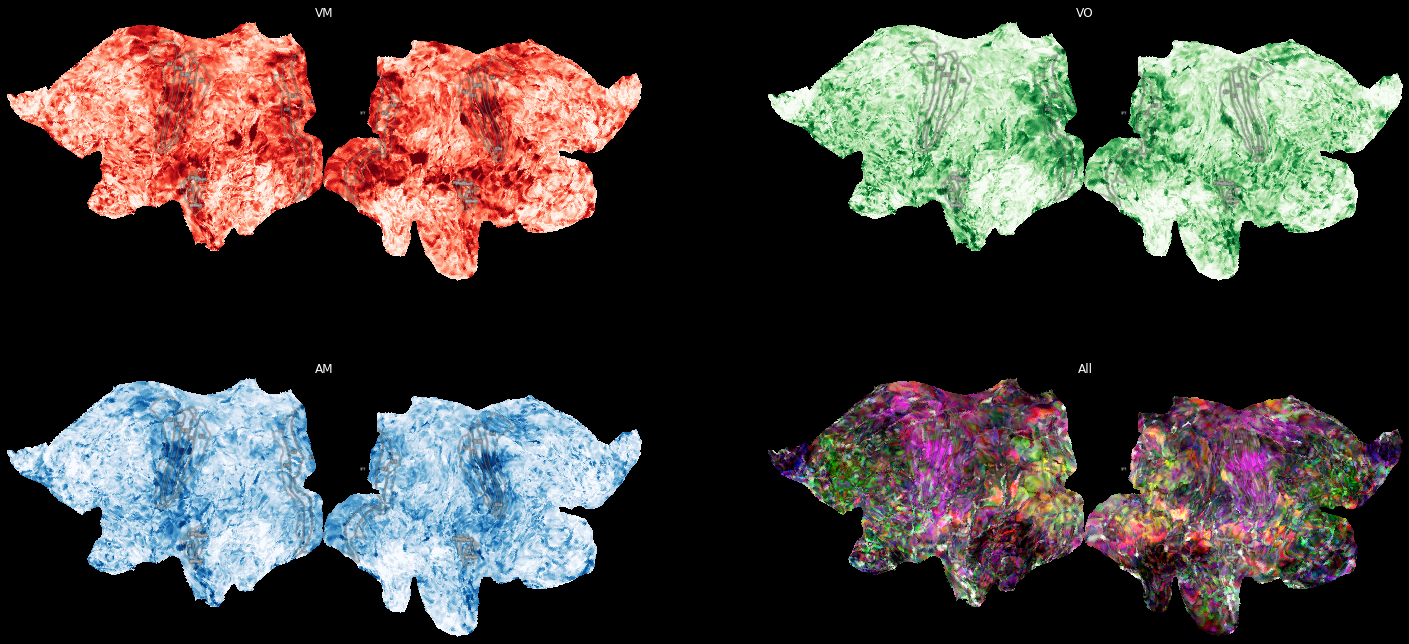

In [54]:
f, axs = plt.subplots(2, 2, figsize=[25,12])

cx.quickshow(red, cmap='reds', with_colorbar=False, fig=axs[0,0], dpi=200)
cx.quickshow(green, cmap='greens', with_colorbar=False, fig=axs[0,1], dpi=200)
cx.quickshow(blue, cmap='blues', with_colorbar=False, fig=axs[1,0], dpi=200)

rgb_vx = cx.VertexRGB(red, green, blue, subject='hcp_999999')
cx.quickshow(rgb_vx, with_colorbar=False, fig=axs[1,1], dpi=200)

axs[0,0].set_title(conditions[0])
axs[0,1].set_title(conditions[1])
axs[1,0].set_title(conditions[2])
axs[1,1].set_title("All")
f.savefig(os.path.join(base_dir, subject, 'colorflatmaps.pdf'))

In [15]:
vo_betas = median_betas_per_condition[1][unique_event_types]
am_betas = median_betas_per_condition[2][unique_event_types]

va_corrs = Parallel(n_jobs=8, verbose=3)\
    (delayed(pearsonr)(vo_betas.iloc[i], am_betas.iloc[i]) for i in range(median_betas_per_condition[0].shape[0]))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 776 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 5896 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 13064 tasks      | elapsed:   10.8s
[Parallel(n_jobs=8)]: Done 22280 tasks      | elapsed:   17.4s
[Parallel(n_jobs=8)]: Done 33544 tasks      | elapsed:   25.4s
[Parallel(n_jobs=8)]: Done 46856 tasks      | elapsed:   35.0s
[Parallel(n_jobs=8)]: Done 62216 tasks      | elapsed:   46.0s
[Parallel(n_jobs=8)]: Done 79624 tasks      | elapsed:   58.9s
[Parallel(n_jobs=8)]: Done 99080 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 120584 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 144136 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 169736 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 170479 out of 170494 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=8)]: 

In [16]:
va_corrs[0]

(0.27287646161786494, 0.30652542116581416)

In [51]:
va_corrs = np.array(va_corrs)
surf_corrs = np.r_[va_corrs[:,0][li], va_corrs[:,0][ri]]
surf_ps = np.r_[va_corrs[:,1][li], va_corrs[:,1][ri]]

mean_surf_rsqs = np.array(surf_rsqs).mean(0)

corr_vx = cx.Vertex(surf_corrs*mean_surf_rsqs, subject='hcp_999999', vmin=-0.5, vmax=0.5, cmap='Spectral')
mrsq_vx = cx.Vertex(mean_surf_rsqs, subject='hcp_999999', vmin=0.2, vmax=0.65, cmap='inferno')

# f, axs = plt.subplots(1,1,figsize=[25,12])
# cx.quickshow(corr_vx, with_colorbar=True, dpi=200, fig=axs)
# axs.set_title('Pearson r between beta weights for visual-only and auditory-motor conditions')
# f.savefig(os.path.join(base_dir, subject, 'va_corrs.pdf'))
# cx.quickshow(cx.Vertex(-np.log10(surf_ps)*mean_surf_rsqs, subject='hcp_999999', vmin=0.0, vmax=3, cmap='inferno'), with_colorbar=False, dpi=200, fig=axs[1])

** (org.inkscape.Inkscape:13104): WARNING **: 21:11:22.947: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:13104): WARNING **: 21:11:22.947: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:13104): WARNING **: 21:11:22.947: attribute 'clip-path' given as CSS
** (org.inkscape.Inkscape:13104): WARNING **: 21:11:22.947: attribute 'clip-path' given as CSS
Fontconfig warning: ignoring UTF-8: not a valid region tag
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 5023 x 2048 pixels (192 dpi)


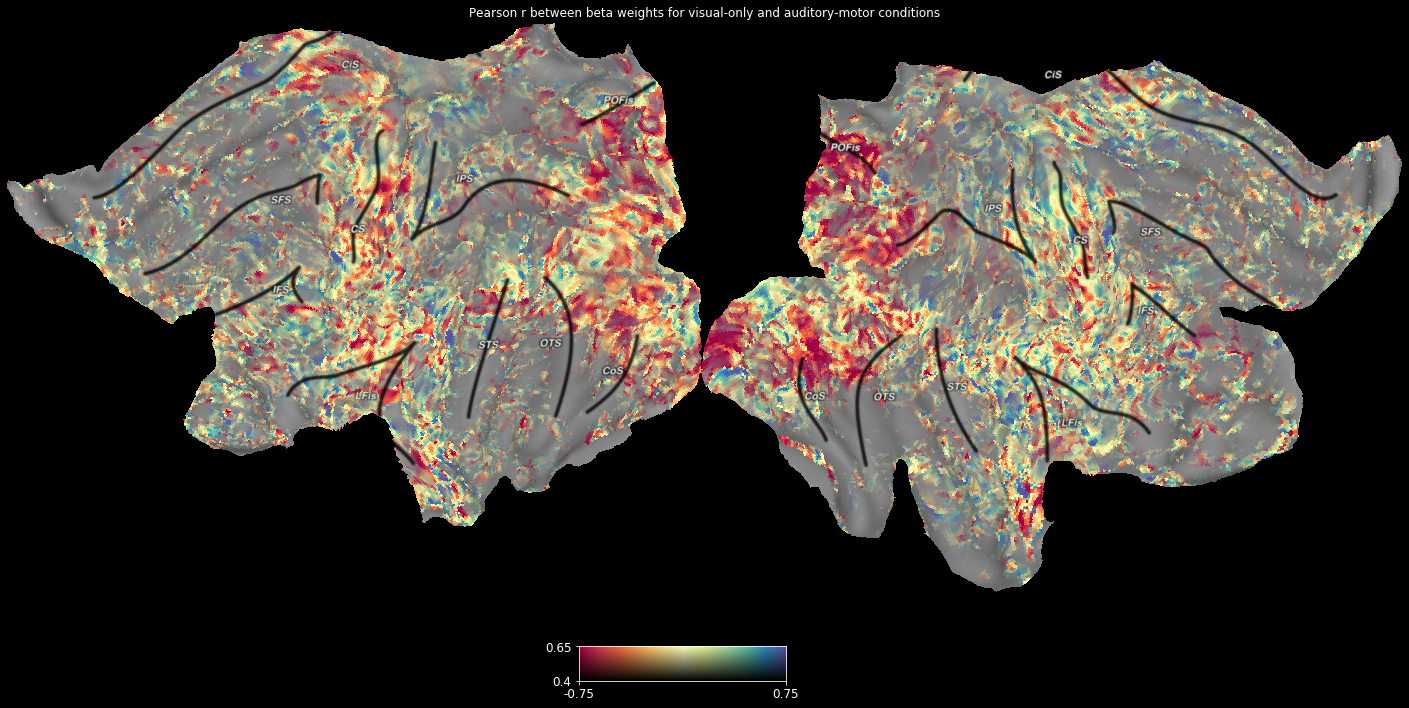

In [48]:
va_corr_2D_V = cx.Vertex2D(surf_corrs, mean_surf_rsqs, vmin=-0.75, vmax=0.75, vmin2=0.4, vmax2=0.65, subject='hcp_999999',cmap='spectral_alpha') # , vmin=0, vmax=0.5

f, axs = plt.subplots(1,1,figsize=[25,12])
cx.quickshow(va_corr_2D_V, 
                 with_labels=True, 
                 with_rois=False, 
                 with_borders=False, 
                 with_sulci=True,
                 with_colorbar=True, 
                 height=2048, 
                 with_curvature=True, 
                 curvature_brightness=0.5,
                 curvature_contrast=0.5,
                 curvature_threshold=False,
                 linecolor='k',
                 fig=axs);
axs.set_title('Pearson r between beta weights for visual-only and auditory-motor conditions')
f.savefig(os.path.join(base_dir, subject, 'va_corrs.pdf'))

In [64]:
cx.webshow({'rgb_vx': rgb_vx})

Started server on port 20809


<JS: window.viewer>

In [63]:
# ds = cx.Dataset({'R:VM_G:VO_B:AM': rgb_vx})
cx.webgl.make_static(os.path.join(base_dir, subject, 'webgl_rgb'), {'R:VM_G:VO_B:AM': rgb_vx.raw})

In [65]:
sp.signal.savgol_filter?

Signature:
sp.signal.savgol_filter(
    x,
    window_length,
    polyorder,
    deriv=0,
    delta=1.0,
    axis=-1,
    mode='interp',
    cval=0.0,
)
Docstring:
Apply a Savitzky-Golay filter to an array.

This is a 1-d filter.  If `x`  has dimension greater than 1, `axis`
determines the axis along which the filter is applied.

Parameters
----------
x : array_like
    The data to be filtered.  If `x` is not a single or double precision
    floating point array, it will be converted to type ``numpy.float64``
    before filtering.
window_length : int
    The length of the filter window (i.e. the number of coefficients).
    `window_length` must be a positive odd integer. If `mode` is 'interp',
    `window_length` must be less than or equal to the size of `x`.
polyorder : int
    The order of the polynomial used to fit the samples.
    `polyorder` must be less than `window_length`.
deriv : int, optional
    The order of the derivative to compute.  This must be a
    nonnegative integer.